In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import Tensor

from train import ModelManager, DIR_ROOT_SAVE, DIR_ROOT_LOG
from utils import get_loader, get_cifar10

# globals
NUM_CLASSES = 10
BATCH_SIZE = 25
NUM_TRAIN = 50000
NUM_TEST = 10000
EPOCHS = 60

NOTEBOOK_NAME = 'prune_50p_cifar10'
PATH_EL2N = os.path.join(DIR_ROOT_SAVE, 'el2n_resnet18_cifar10', 'general.pt')
PATH_FORGET = os.path.join(DIR_ROOT_SAVE, 'flip_cifar10', 'model', 'other.pt')
PATH_LOG = os.path.join(DIR_ROOT_LOG, NOTEBOOK_NAME, 'test_acc.pt')

print('train on:', ModelManager.DEVICE)

train_idx = np.arange(NUM_TRAIN, dtype=int)
test_idx = np.arange(NUM_TEST, dtype=int)
dataset_train, dataset_test, dataset_train_for_test, dataset_train_raw = get_cifar10()
# loader_train = get_loader(dataset_train, train_idx, BATCH_SIZE, shuffle=True)
loader_test = get_loader(dataset_test, test_idx, BATCH_SIZE, shuffle=False)
loader_train_ordered = get_loader(dataset_train_for_test, train_idx, BATCH_SIZE, shuffle=False)
Y_train = Tensor(dataset_train.targets)[train_idx].type(torch.int64)
Y_test = Tensor(dataset_test.targets)[test_idx].type(torch.int64)

# get prune scores
data = torch.load(PATH_EL2N)

ensemble_softmax = data['ensemble_softmax']
ensemble_pred = data['ensemble_pred']
ensemble_pred_sum = data['ensemble_pred_sum']
ensemble_std = data['ensemble_std']
el2n_scores = data['el2n_scores']
change_counter = torch.load(PATH_FORGET)['change_counter']
true_forget = torch.load(PATH_FORGET)['true_forget']
# forgetting_model = ModelManager(NUM_CLASSES, 'forgetting', load=True)
# change_counter = forgetting_model.data_other['change_counter']
#
# ensemble_softmax = torch.arange(NUM_TRAIN)
# ensemble_pred = torch.arange(NUM_TRAIN)
# ensemble_pred_sum = torch.arange(NUM_TRAIN)
# # ensemble_std =  torch.arange(NUM_TRAIN)
# el2n_scores = torch.arange(NUM_TRAIN)
# change_counter = torch.arange(NUM_TRAIN)

idx_sorted_el2n = el2n_scores.sort()[1].numpy()
idx_sorted_forgetting = change_counter.sort()[1].numpy()
idx_sorted_std = ensemble_std.sum(dim=1).sort()[1].numpy()
idx_sorted_pred_sum = ensemble_pred_sum.sort()[1].numpy()[::-1]
idx_true_forget = true_forget.sort()[1].numpy()
idx_random_prune = np.random.choice(np.arange(NUM_TRAIN), NUM_TRAIN, replace=False)

idx_sorted = {'random': idx_random_prune, 'el2n': idx_sorted_el2n, 'std': idx_sorted_std,
              'pred_sum': idx_sorted_pred_sum, 'flip': idx_sorted_forgetting, 'forget': idx_true_forget}
# idx_sorted

data = pd.DataFrame({
    'EL2N': el2n_scores.numpy(),
    'Std': ensemble_std.sum(dim=1).numpy(),
    'True p sum': ensemble_pred_sum.numpy(),  # number of models that right on each example
    'flip': change_counter.numpy(),
    'forget': true_forget.numpy()
})
data.corr()

train on: cuda
Files already downloaded and verified
Files already downloaded and verified


,EL2N,Std,True p sum,flip,forget
EL2N,1.000000,0.780107,-0.944299,0.658627,0.399751
Std,0.780107,1.000000,-0.660269,0.586532,0.377763
True p sum,-0.944299,-0.660269,1.000000,-0.627331,-0.350162
flip,0.658627,0.586532,-0.627331,1.000000,0.770378
forget,0.399751,0.377763,-0.350162,0.770378,1.000000


In [2]:
regular_model = ModelManager(NUM_CLASSES, 'no_prune', dir_=NOTEBOOK_NAME, load=True)
print(regular_model.model)
# loader_train = get_loader(dataset_train, train_idx, BATCH_SIZE, True)
# regular_model.train(loader_train, loader_test, loader_test, EPOCHS)

num_train = int(NUM_TRAIN * (50. / 100.))
models = [regular_model]


print()
for name, idx in idx_sorted.items():
    print(f'====     train model with 50% prune according to {name} most hard     ======')

    # loader_train = get_loader(dataset_train, idx[-num_train:], BATCH_SIZE, True)
    model_manager = ModelManager(NUM_CLASSES, f'{NOTEBOOK_NAME}_{name}', dir_=NOTEBOOK_NAME, load=True)
    # model_manager.train(loader_train, loader_test, loader_test, EPOCHS)
    models.append(model_manager)
    print()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): Identity()
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), p

In [3]:
[model.name for model in models]

['no_prune',
 'prune_50p_cifar10_random',
 'prune_50p_cifar10_el2n',
 'prune_50p_cifar10_std',
 'prune_50p_cifar10_pred_sum',
 'prune_50p_cifar10_flip',
 'prune_50p_cifar10_forget']

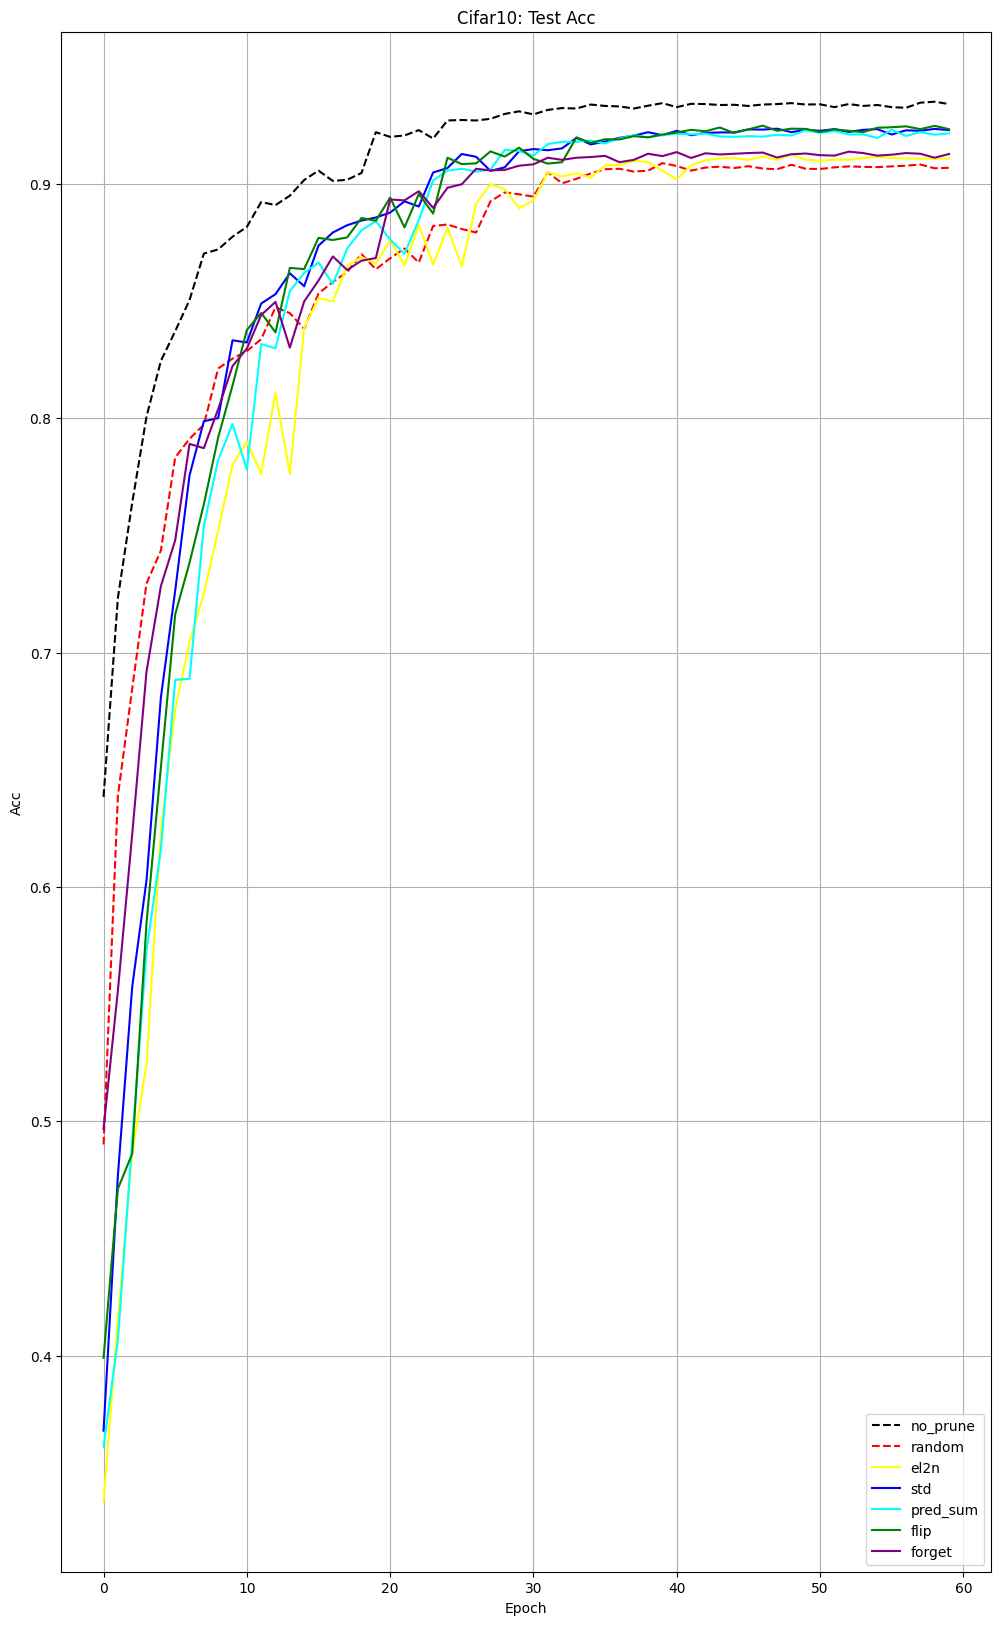

In [8]:
colors = ('black', 'red', 'yellow', 'blue', 'cyan', 'green', 'purple')
#          no       rand    el2n     std     sum     flip      forget
markers = ('dashed', 'solid')

plt.figure(figsize=(12, 20))
for i, model in enumerate(models):
    plt.plot(range(model.data['epochs']), model.data['valid']['acc'],
             label=model.name.split(NOTEBOOK_NAME)[-1][1:] if i != 0 else model.name,
             c=colors[i], linestyle=markers[0] if i < 2 else markers[1])
plt.legend(loc='lower right')
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.title('Cifar10: Test Acc')
plt.show()